In [3]:
!pip install extinction
# remove if duplicate
import pandas as pd
import numpy as np
import os
import glob
from extinction import fitzpatrick99
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_DIR = "mallorn-challenge/"
WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}
log_df = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
print(log_df.head(), log_df.shape)

                  object_id       Z  Z_err    EBV SpecType  \
0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   

                               English Translation     split  target  
0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
2                  Elves +  lover (fem.)  + breath  split_01       0  
3                    moon +  roof  +  noble maiden  split_01       0  
4            jewel, Silmaril  + father + Wild Man   split_01       0   (3043, 8)


In [10]:

def apply_de_extinction(df):
    wl_values = df['Filter'].map(WAVELENGTHS)
    ebv_values = df['EBV'].astype(float)

    a_lambda = np.full(len(df), np.nan)
    valid = ~wl_values.isna()

    if valid.any():
        
        unit_extinction = fitzpatrick99(wl_values[valid].values.astype(float), 1.0)
        a_lambda[valid] = unit_extinction * (ebv_values[valid] * 3.1)
    
    df['Flux_Real'] = df['Flux'] * (10 ** (a_lambda / 2.5))
    return df


In [13]:
def process_flux(df):
    eps = 1e-6
    flux_err_safe = df['Flux_err'].replace(0, np.nan)
    denom = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df['Flux'], 2) / denom
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq,
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)


In [16]:
def process_data_pipeline(log_df, is_train=True):
    file_name = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"
    cols_to_use = ['object_id', 'EBV', 'Z']
    if is_train:
        cols_to_use.append('target')

    log_lookup = log_df[cols_to_use]
    all_features = []
    for i in range(1, 21):
        split_path = os.path.join(DATA_DIR, f"Split_{i:02d}", file_name)
        if os.path.exists(split_path):
            print(f"Processing {split_path}...")
            chunk_df = pd.read_csv(split_path)
            chunk_df = chunk_df.merge(log_lookup[['object_id', 'EBV', 'Z']], on='object_id', how='left')
            chunk_df = apply_de_extinction(chunk_df)
            chunk_df = process_flux(chunk_df)
            agg_dict = {
                'Flux_Real': ['max', 'mean', 'min', 'std'],
                'Time (MJD)': ['min', 'max'],
                'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
                'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
            }
            features = chunk_df.groupby(['object_id', 'Filter']).agg(agg_dict)
            features = features.unstack()
            features.columns = ['_'.join(map(str, col)).strip() for col in features.columns.values]
            features = features.reset_index()
            features = features.merge(log_lookup[['object_id', 'Z']], on='object_id', how='left')
            features['is_galactic'] = (features['Z'] < 0.005).astype(int)
            features['Log_Z'] = np.log1p(features['Z'])
            if 'Flux_Real_max_g' in features.columns and 'Flux_Real_max_r' in features.columns:
                features['color_g_r'] = features['Flux_Real_max_g'] - features['Flux_Real_max_r']
            else:
                features['color_g_r'] = np.nan
            if 'Flux_Real_max_u' in features.columns and 'Flux_Real_max_g' in features.columns:
                features['color_u_g'] = features['Flux_Real_max_u'] - features['Flux_Real_max_g']
            else:
                features['color_u_g'] = np.nan
            if 'Time_max_g' in features.columns and 'Time_min_g' in features.columns:
                duration_obs = features['Time_max_g'] - features['Time_min_g']
                features['duration_rest'] = duration_obs / (1 + features['Z'])
            else:
                features['duration_rest'] = np.nan
            all_features.append(features)
            del chunk_df
    if len(all_features) > 0:
        final_df = pd.concat(all_features, ignore_index=True)
        if is_train:
            final_df = final_df.merge(log_lookup[['object_id', 'target']], on='object_id', how='left')
        return final_df
    else:
        print("No data files found.")
        return None


In [17]:
# Step 1 Read file log
print(" Reading doc files log...")
train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
# Step 2 Call function process_data_pipeline to process data
print(" Processing training data...")
final_df = process_data_pipeline(train_log, is_train=True)
# Step 3 Check conclusions
if final_df is not None:
    print(" Final training data shape:", final_df.shape)
else:
    print(" Data processing failed.")

 Reading doc files log...
 Processing training data...
Processing mallorn-challenge/Split_01\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_12\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_13\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_14\train_full_lightcurves.

In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import numpy as np
import pandas as pd

# 1. Chuẩn bị dữ liệu
X = final_df.drop(columns=['object_id', 'target'])
y = final_df['target'].values
object_ids = final_df['object_id'].values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Mảng lưu kết quả dự đoán "Hợp sức"
oof_preds_ensemble = np.zeros(len(final_df))

# Lưu danh sách model để dùng cho tập Test sau này
models_lgb = []
models_cb = []

print("🚀 Bắt đầu Train Ensemble (LightGBM + CatBoost)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    # --- A. CHIA DỮ LIỆU ---
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    # --- B. XỬ LÝ SMOTE (Chung cho cả 2 model) ---
    X_train_filled = X_train.fillna(0) # Fill 0 để chạy được SMOTE
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filled, y_train)
    
    # Chuẩn bị dữ liệu Val (Fill 0 cho đồng bộ)
    X_val_filled = X_val.fillna(0)

    # --- C. TRAIN MODEL 1: LIGHTGBM ---
    clf_lgb = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)
    clf_lgb.fit(X_train_resampled, y_train_resampled, 
                eval_set=[(X_val_filled, y_val)])
    models_lgb.append(clf_lgb)
    # Dự đoán xác suất LGBM
    prob_lgb = clf_lgb.predict_proba(X_val_filled)[:, 1]

    # --- D. TRAIN MODEL 2: CATBOOST (Nhân tố mới) ---
    # CatBoost chạy khá nhanh và tự xử lý tốt
    clf_cb = CatBoostClassifier(
        iterations=1000, 
        learning_rate=0.05, 
        depth=6,
        verbose=0, # Tắt log cho đỡ rối
        allow_writing_files=False, # Không tạo rác
        random_seed=42
    )
    clf_cb.fit(X_train_resampled, y_train_resampled, 
               eval_set=(X_val_filled, y_val),
               early_stopping_rounds=50)
    models_cb.append(clf_cb)
    
    # Dự đoán xác suất CatBoost
    prob_cb = clf_cb.predict_proba(X_val_filled)[:, 1]

    # --- E. HỢP SỨC (ENSEMBLE) ---
    # Lấy trung bình cộng (50-50)
    # Bạn có thể chỉnh tỷ lệ, ví dụ: 0.6 * LGBM + 0.4 * CB nếu LGBM tốt hơn
    ensemble_prob = (0.5 * prob_lgb) + (0.5 * prob_cb)
    
    # Lưu kết quả
    oof_preds_ensemble[val_idx] = ensemble_prob

    # Check nhanh F1 ở ngưỡng 0.5 (Chỉ để tham khảo)
    temp_preds = (ensemble_prob >= 0.5).astype(int)
    score = f1_score(y_val, temp_preds)
    print(f"Fold {fold+1}: Combined F1 (Default 0.5) = {score:.4f}")

print("✅ Đã train xong!")

🚀 Bắt đầu Train Ensemble (LightGBM + CatBoost)...
Fold 1: Combined F1 (Default 0.5) = 0.4000
Fold 2: Combined F1 (Default 0.5) = 0.1569
Fold 3: Combined F1 (Default 0.5) = 0.2449
Fold 4: Combined F1 (Default 0.5) = 0.3273
Fold 5: Combined F1 (Default 0.5) = 0.3043
✅ Đã train xong!


Ngưỡng tối ưu (Ensemble): 0.1011
F1 cao nhất đạt được: 0.3672


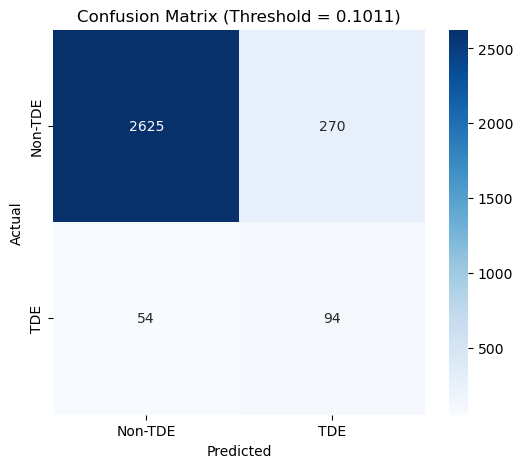

In [21]:
# Tìm ngưỡng tối ưu cho kết quả Ensemble
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y, oof_preds_ensemble) # <--- Dùng biến ensemble
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Ngưỡng tối ưu (Ensemble): {best_threshold:.4f}")
print(f"F1 cao nhất đạt được: {np.max(f1_scores):.4f}")

# Vẽ lại Confusion Matrix để tận hưởng thành quả
final_preds = (oof_preds_ensemble >= best_threshold).astype(int)
cm = confusion_matrix(y, final_preds)
# ... (Code vẽ biểu đồ giữ nguyên)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()